<a href="https://colab.research.google.com/github/Paradorn657/recurrent_nearal/blob/master/naive_forecasting%26moving_avr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("series")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),1 / np.exp(3 * season_time))
      
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
  #seed เป็น ค่า Probability ในการสุ่มตัวเลข
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level 

In [0]:
time = np.arange(4*365+1)
slope = 0.05
amplitude = 40
series = 10 + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) 
# series -> ลำดับเหตุการณ์
# amplitude -> ความสูงของกราฟ



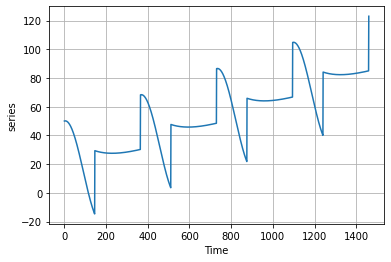

In [5]:
plot_series(time,series)

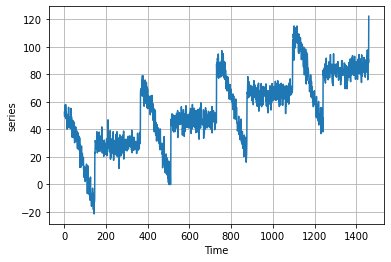

In [6]:
series = 10 + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + white_noise(time,5,42)
plot_series(time,series)

In [7]:
series # มี 1461 ตัวเพราะมี 0 ด้วย 0->1460 4 ปี

array([ 52.48357077,  49.35275206,  53.31473872, ...,  91.37325376,
        88.32382529, 122.30772008])

In [0]:
train_series = series[:1000]
train_time = time[:1000]
valid_series = series[1000:]

valid_time = time[1000:]
# เอาตัว 1000 ถึงตัวสุดท้าย

In [0]:
naive_forecast = series[999:-1]
# เอาตัว 999 ถึงตัวก่อนสุดท้าย [include,exclude] 
# ทำแบบนี้เพื่อให้ size เท่ากัน และให้เห็นเส้นน้ำเงินเส้นสุดท้าย

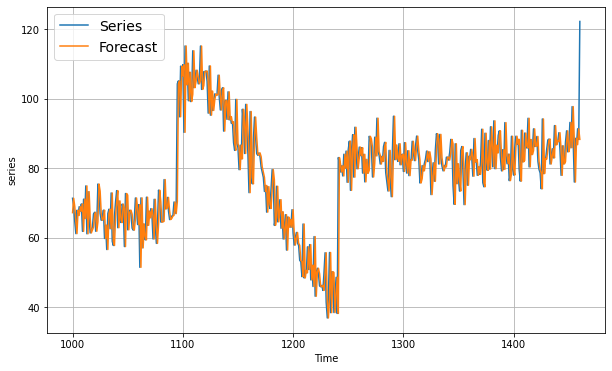

In [10]:
plt.figure(figsize=(10, 6))
plot_series(valid_time, valid_series, label="Series")
plot_series(valid_time, naive_forecast, label="Forecast")

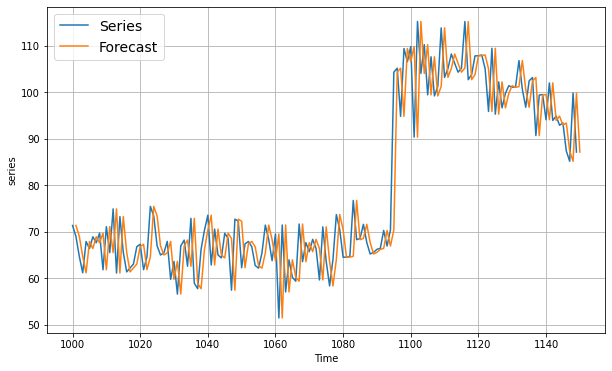

In [11]:
plt.figure(figsize=(10, 6))
plot_series(valid_time, valid_series, start=0, end=150, label="Series")
plot_series(valid_time, naive_forecast, start=1, end=151, label="Forecast")

**มันก็คือข้อมูลเดียวแค่ เส้นส้ม ถูกเลื่อนมาหนึ่งวัน**
เส้นสีน้ำเงิน คือ เส้นที่แท้จริงและเส้นสีส้มคือเส้นที่ naive forecast


# **การทำ naive ข้างต้นเพื่อเป็นพื้นฐานให้เห็นภาพ แต่เส้นส้มเราต้อง **predictทำนายอนาคตไม่ใช่** ตัดจาก valid series **

ข้างล่างนี้คือการวัดค่า loss

In [0]:
import tensorflow as tf
%tensorflow_version 2.x

In [13]:
tf.keras.losses.mean_absolute_error(valid_series,naive_forecast).numpy()

5.9379085153216735

loss ค่านี้ คือ ค่าที่เราเอา naive_forecast ตัวที่ 999 เป็นตัวแรก และ ไม่เอาตัวสุดท้าย

# **Moving average**

In [0]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    #1461-30 = 1421
    #window_size ก็คือ เส้นใน 1 เดือน
    forecast.append(series[time:time + window_size].mean())
    #เอาทุกๆ 30 วันมา หา avr แล้วเด้งออกเป็น 1
  return np.array(forecast)
  

In [15]:
valid_series.shape

(461,)

In [16]:
moving_avg = moving_average_forecast(series, 30)
moving_avg.shape

(1431,)

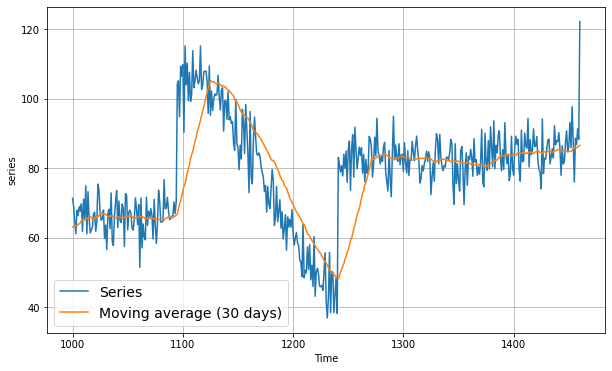

In [17]:
moving_avg = moving_average_forecast(series, 30)[970:]

plt.figure(figsize=(10, 6))
plot_series(valid_time, valid_series, label="Series")
plot_series(valid_time, moving_avg, label="Moving average (30 days)")

In [18]:
tf.keras.losses.mean_absolute_error(valid_series,moving_avg).numpy()

7.142418570620878

In [28]:
series.shape

(1461,)

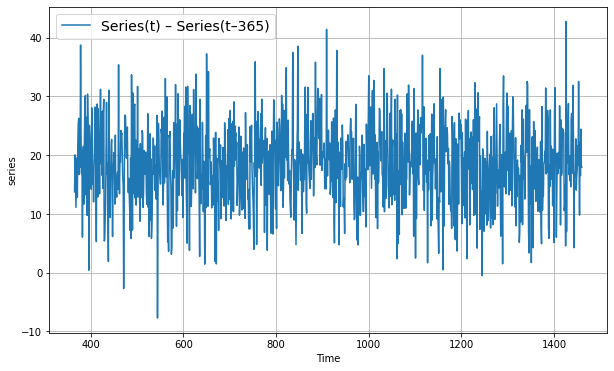

In [19]:
diff_series = (series[365:] - series[:-365])
#[365: 1461] ->1096 ตัว ที่เอามา แต่ละฝั่ง ซ้ายขวา เอามาลบกับ
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

# รูปนี้คือ series ในช่วง [365:1461]
[365: 1461] ->1096 ตัว ที่เอามา แต่ละฝั่ง ซ้ายขวา เอามาลบกับ
ซ้าย มี 1096ตัวจาก ขวาก็มี 1096 ตัว

In [20]:
diff_series.shape

(1096,)

In [29]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[605:]
diff_moving_avg.shape

(461,)

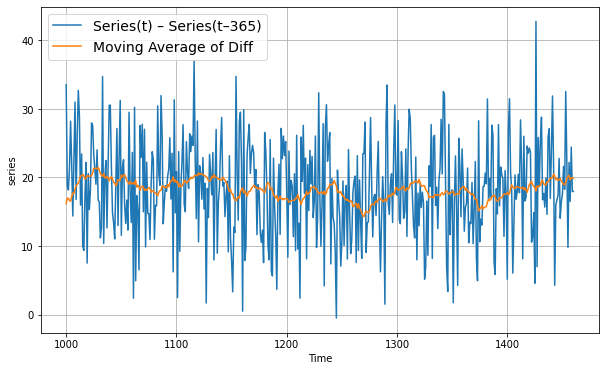

In [24]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[605:]

plt.figure(figsize=(10, 6))
plot_series(valid_time, diff_series[635:], label="Series(t) – Series(t–365)")
plot_series(valid_time, diff_moving_avg, label="Moving Average of Diff")
plt.show()

# หา ค่าเฉลี่ยน mean ออกมาจากโดย เอา dif series ไปใส่
ใน function ออกมาเป็น diff moving avg

In [26]:
diff_moving_avg_plus_past = series[635:-365] + diff_moving_avg
diff_moving_avg_plus_past.shape

(461,)

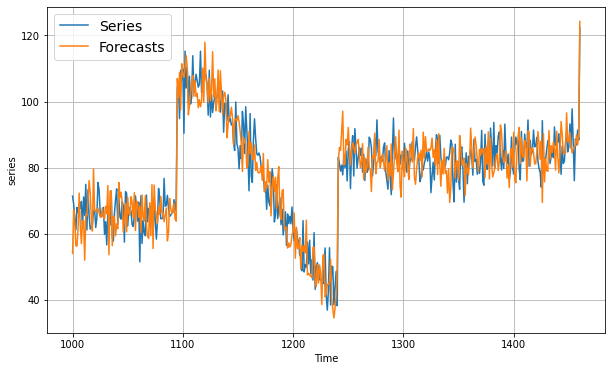

In [32]:
diff_moving_avg_plus_past = series[635:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(valid_time, valid_series, label="Series")
plot_series(valid_time, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [33]:
tf.keras.metrics.mean_absolute_error(valid_series,diff_moving_avg_plus_past).numpy()

5.90324159381316

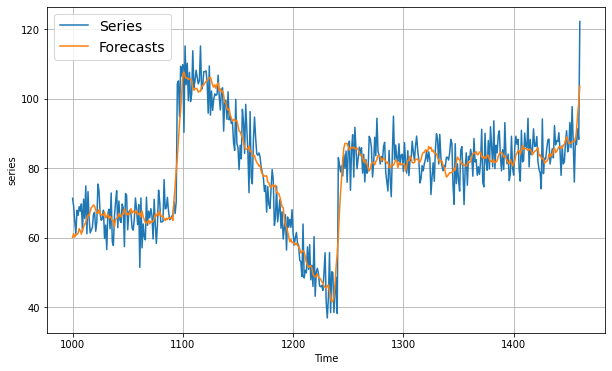

In [61]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[630:1100], 9) + diff_moving_avg
# เราเอา 1000-หนึ่งปีที่แล้วเพื่อหาค่า เฉลี่ย (1000-365)-> 635 ถึง 1100 เพราะค่า noise มันมาจากปีที่แล้ว (มันเป็นแพทเทินคลื่นหลายๆลูก) แล้วก็ขยับหาค่าเฉลี่ยเอา เฉพาะข้างซ้าย
plt.figure(figsize=(10, 6))
plot_series(valid_time, valid_series, label="Series")
plot_series(valid_time, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [36]:
diff_moving_avg_plus_smooth_past.shape

(461,)

In [62]:
tf.keras.metrics.mean_absolute_error(valid_series,diff_moving_avg_plus_smooth_past).numpy()

4.55686591213934